# Cyber Bullying Detector

In [3]:
from typing import List
import nltk
import os
import numpy as np
import pandas as pd
import string
from nltk.corpus import stopwords
from enchant.checker import SpellChecker
# from nltk.stem import WordNetLemmatizer
import swifter
import tensorflow.compat.v1 as tf
import math
from collections import Counter
import re
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
def train_test_split(X, y, test_size, random_state):
    # x_train, y_train, x_test, y_test
    np.random.seed(random_state)
    num_rows = X.shape[0]
    mask_train = np.zeros(num_rows, dtype=bool)
    mask_train[np.random.choice(num_rows, int(num_rows * test_size), replace=False)] = True
    return X[~mask_train], X[mask_train], y[~mask_train], y[mask_train]


x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=1)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, random_state=1)



def classification_report(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    TP = y_pred[y_pred[y_true == 0] == 0].size
    TN = y_pred[y_pred[y_true == 1] == 1].size
    FP = y_pred[y_pred[y_true == 0] == 1].size
    FN = y_pred[y_pred[y_true == 1] == 0].size
    precision_0 = TP/(TP+FP)
    precision_1 = TN / (TN+FN)
    recall_0 = TP / (TP+FN)
    recall_1 = TN / (TN + FP)
    f_score_0 = 2*precision_0*recall_0/(precision_0+recall_0)
    f_score_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
    print("\tprecision\trecall\tf1-score")
    print(f"0\t  {precision_0}\t {recall_0}\t {f_score_0}\n1\t  {precision_1}\t {recall_1}\t {f_score_1}")
    print(f"accuracy\t\t\t{(TP+TN)/(TP+FP+TN+FN)}")
    return np.array([[TP,FN],[FP,TN]])


In [3]:
def get_words_count(text:str) -> (pd.Series,int):
    text = re.findall(r"(?u)\b\w\w+\b",text)
    words_count = pd.Series(Counter(text))
    words_count = words_count.drop(labels=set(words_count.keys()).difference(set(stopwords.words('english'))))
    return words_count,len(text)
    
class CountVectorizer:
    def __init__(self,X:pd.Series,min_df=0.0001):
        self.words_count,text_len = get_words_count(" ".join(X.ravel()))
        self.words_count = self.words_count[self.words_count > min_df*text_len]

    def transform(self,X:pd.Series):
        def helper(row_text):
            res = get_words_count(row_text)[0]
            return res.drop(set(res.keys()).difference(self.words_count.keys()))
        return X.swifter.apply(helper).fillna(0)

## Logitic regression

In [4]:
def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)
eps = 0.2 #1e-2

In [5]:
def build_logisticRegression(features:int):
    x = tf.placeholder(tf.float64, [None, features])
    y_train_variable = tf.placeholder(tf.float64, [None, 1])
    W = tf.Variable(tf.random.uniform([features, 1],dtype=tf.float64))
    b = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
    return tf.add(tf.matmul(x, W), b)

In [6]:
def predict(sess,X_test,x_placeholder,y_final,thr=0.5):
    predictions = sess.run(tf.nn.sigmoid(sess.run(y_final, feed_dict={x_placeholder: X_test})))
    predictions[predictions >= thr] = 1
    predictions[predictions < thr] = 0
    print(classification_report(y_test, predictions))
    cc = confusion_matrix(y_test, predictions, labels=[0, 1])
    sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.show()
    return predictions

In [7]:
def train(sess,final_y,y_train_variable,x_placeholder,adaptive=True,learning_rate=0.1,epoch=30,batch_size=200,model_name="MLP"):
    # assume x_train,y_train,x_test,y_test,x_validation, y_validation are allready declared
    losses = []
    test_loss = []
    valid_loss = []
    learning_rate_tensor = tf.placeholder(tf.float64, shape=[])  # tensor for implement dynamic learning rate 
    lr = learning_rate
    w1_weight = (y_train == 1).sum()
    w0_weight = (y_train == 0).sum()
    loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=y_train_variable, 
            logits= tf.cast(final_y, tf.float64), pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
    update = tf.train.AdamOptimizer(learning_rate_tensor).minimize(loss) 
    sess.run(tf.global_variables_initializer())
    rows_num = x_train.shape[0]
    for i in range(epoch):
        for counter_step in range(rows_num//batch_size):
            X_batch = x_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            sess.run(update, feed_dict={x_placeholder: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
        loss_value = sess.run(loss, feed_dict={x_placeholder: x_train, y_train_variable: y_train,learning_rate_tensor:lr})
        loss_value_test = sess.run(loss, feed_dict={x_placeholder:x_test, y_train_variable: y_test,learning_rate_tensor:lr})
        loss_value_validation = sess.run(loss, feed_dict={x_placeholder:x_validation, y_train_variable: y_validation,learning_rate_tensor:lr})
        print(f"Iteration {i+1}, loss = {loss_value}")
        losses.append(loss_value)
        test_loss.append(loss_value_test)
        valid_loss.append(loss_value_validation)
        if adaptive and losses[i] > losses[i-1]:  # check if the loss divergence
            print("=====change learning rate=========")
            lr = lr/10
    save_loss(losses, filename=f"{model_name}_train_error.txt")
    save_loss(test_loss, filename=f"{model_name}_test_error.txt")
    save_loss(valid_loss, filename=f"{model_name}_validation_error.txt")
    return losses,test_loss,valid_loss

## Preprocess

In [19]:

df= pd.read_csv("../Data/ver1.csv", index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)
X = df["Text"] .swifter.apply(lambda text : re.sub(r'\d+', '', text).lower())
y= df["oh_label"]
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=1)

vectorizer = CountVectorizer(pd.Series(x_train))
x_train = vectorizer.transform(pd.Series(x_train))
x_test = vectorizer.transform(pd.Series(x_test))
x_validation = vectorizer.transform(pd.Series(x_validation))

mean,std = x_train.mean(),x_train.std()
x_train = x_train.apply(lambda row : (row - mean)/std, axis=1)
x_test = x_test.apply(lambda row : (row - mean)/std, axis=1)
x_train

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/350 [00:00<?, ?it/s]

<ipython-input-3-3df07d3a2bb5>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_count = pd.Series(Counter(text))


Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

,all,are,so,you,re,the,of,them,to,more,...,here,isn,wouldn,over,nor,couldn,both,she,between,wasn
0,1.913416,0.685053,3.682635,0.497512,2.411646,-0.232034,0.129936,2.725696,-0.057719,2.614304,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
1,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
2,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.232034,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
3,-0.326369,0.685053,-0.389789,-0.509015,-0.276494,0.335882,2.766313,-0.237017,2.186910,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
4,1.913416,-0.375870,1.646423,0.497512,-0.276494,-0.232034,0.129936,-0.237017,1.625753,2.614304,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,-0.326369,0.685053,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.057719,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
346,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
347,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,4.421155,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
348,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701


,all,are,so,you,re,the,of,them,to,more,...,here,isn,wouldn,over,nor,couldn,both,she,between,wasn
0,1.913416,0.685053,3.682635,0.497512,2.411646,-0.232034,0.129936,2.725696,-0.057719,2.614304,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
1,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
2,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.232034,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
3,-0.326369,0.685053,-0.389789,-0.509015,-0.276494,0.335882,2.766313,-0.237017,2.186910,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
4,1.913416,-0.375870,1.646423,0.497512,-0.276494,-0.232034,0.129936,-0.237017,1.625753,2.614304,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,-0.326369,0.685053,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.057719,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
346,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
347,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,4.421155,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701
348,-0.326369,-0.375870,-0.389789,-0.509015,-0.276494,-0.515992,-0.529159,-0.237017,-0.618876,-0.272152,...,-0.230051,-0.197962,-0.107367,-0.162227,-0.071796,-0.075701,-0.131879,-0.131879,-0.120214,-0.075701


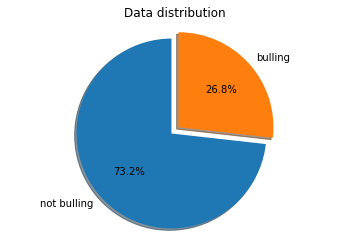

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
fig1, ax1 = plt.subplots()
ax1.pie(y_train.value_counts(), explode = [0,0.1], labels=["not bulling", "bulling"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Data distribution")
plt.show()

In [10]:
X_test_counts = count_vect.transform(x_test)
x_test = pd.DataFrame(X_test_counts.toarray(), columns=count_vect.get_feature_names())

In [11]:
X_validation_counts = count_vect.transform(x_validation)
x_validation = pd.DataFrame(X_validation_counts.toarray(), columns=count_vect.get_feature_names())

In [19]:
# oversample implementation
# from imblearn.over_sampling import SMOTE

# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import RandomOverSampler 
# oversample = RandomOverSampler(random_state=42,sampling_strategy=0.9)
# x_train, y_train = oversample.fit_resample(x_train, y_train)

In [62]:
import seaborn as sns
logistic = LogisticRegression(fx_train,fy_train, x_validation, y_validation.values,epoch=80,learning_rate=0.01,batch_size=100)
predictions = logistic.predict(x_test)
print(classification_report(y_test, predictions))

iteration 0: loss value is: 14.16044174511345
iteration 1: loss value is: 9.839322507527895
iteration 2: loss value is: 6.588793422275144
iteration 3: loss value is: 4.104783509228417
iteration 4: loss value is: 2.056861569397093
iteration 5: loss value is: 1.5864518894831
iteration 6: loss value is: 1.3755819299230996
iteration 7: loss value is: 1.2223847858112258
iteration 8: loss value is: 1.09863626713004
iteration 9: loss value is: 0.9963307045043086
iteration 10: loss value is: 0.9171610120633494
iteration 11: loss value is: 0.8515141882932133
iteration 12: loss value is: 0.8046980379556854
iteration 13: loss value is: 0.7699294559922631
iteration 14: loss value is: 0.7441556796564157
iteration 15: loss value is: 0.7248158189823127
iteration 16: loss value is: 0.7072831797921149
iteration 17: loss value is: 0.701319663411078
iteration 18: loss value is: 0.6879560767328968
iteration 19: loss value is: 0.6856731591157471
iteration 20: loss value is: 0.6817593166151092
iteration 21:

0.8308

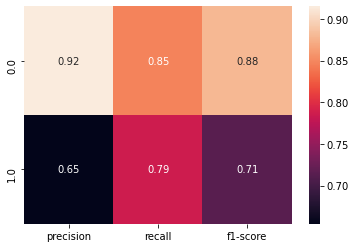

In [66]:
clf_report = classification_report(y_test, predictions, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
clf_report["accuracy"]

Text(33.0, 0.5, 'True label')

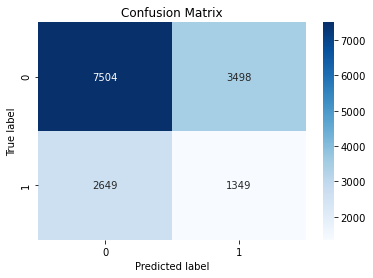

In [67]:
cc = confusion_matrix(y_validation, predictions, labels=[0, 1])
sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.ylabel("True label")

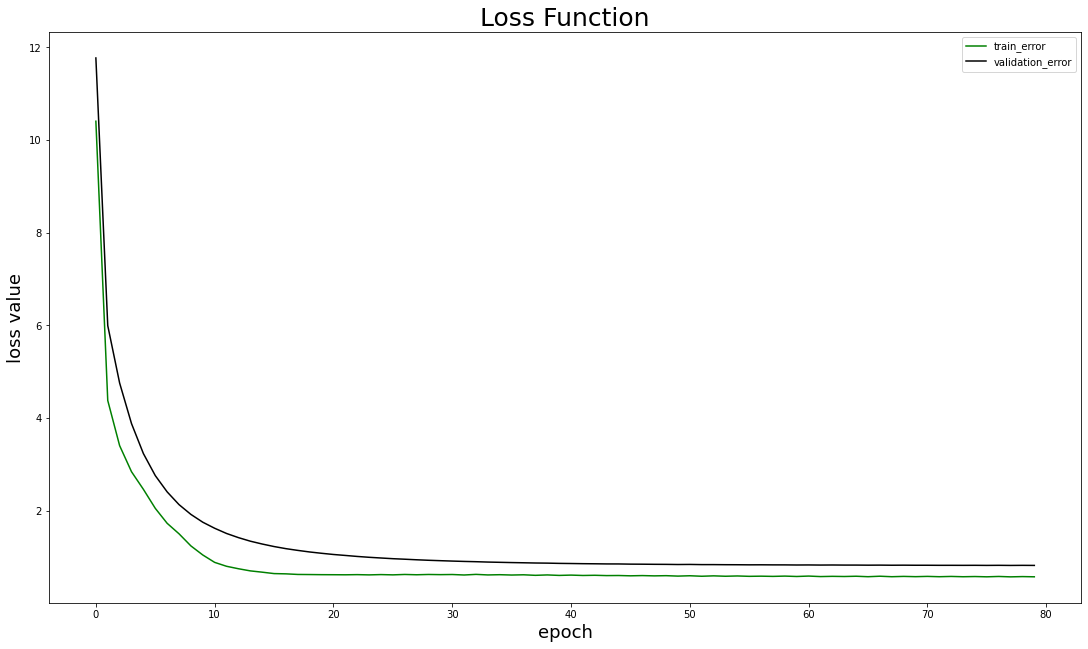

In [57]:
import matplotlib.pyplot as plt 
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
data_train = np.loadtxt("train_error.txt")
data_validation = np.loadtxt("validation_error.txt")
plt.plot(data_train,color='g',label='train_error')
plt.plot(data_validation,color='k',label='validation_error')
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


In [24]:
y_test = y_test.values
y_test = y_test.reshape((y_test.size,1))
y_train = y_train.values
y_train = y_train.reshape((y_train.size,1))
y_validation = y_validation.values
y_validation = y_validation.reshape((y_validation.size,1))

Iteration 1, loss = 78927.65600946955
Iteration 2, loss = 9090.351707360893
Iteration 3, loss = 413.18401416546374
Iteration 4, loss = 1324.9566723264384
=====change learning rate=========
Iteration 5, loss = 141.03168853091051
Iteration 6, loss = 140.2832337372657
Iteration 7, loss = 107.49269362436242
Iteration 8, loss = 87.54414595279812
Iteration 9, loss = 96.05166198949598
=====change learning rate=========
Iteration 10, loss = 64.9329584946496
Iteration 11, loss = 63.08637360705539
Iteration 12, loss = 64.52088167174203
=====change learning rate=========
Iteration 13, loss = 61.62791884413005
Iteration 14, loss = 62.61501770983998
=====change learning rate=========
Iteration 15, loss = 58.77921454815267
Iteration 16, loss = 58.76740504624874
Iteration 17, loss = 58.78733089865452
=====change learning rate=========
Iteration 18, loss = 58.68235712593717
Iteration 19, loss = 58.67077792727931
Iteration 20, loss = 58.66113038173951
Iteration 21, loss = 58.64428211912297
Iteration 22

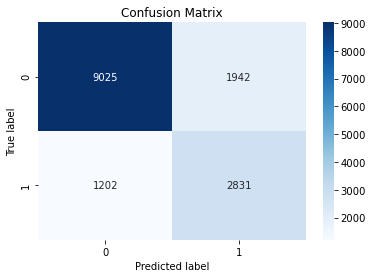

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [35]:

config = tf.ConfigProto(device_count={"CPU": 8},inter_op_parallelism_threads=4,intra_op_parallelism_threads=4)
sess = tf.Session(config=config)
features = x_train.shape[1]
x_placeholder = tf.placeholder(tf.float64, [None, features])
y_train_variable = tf.placeholder(tf.float64, [None, 1])

#1000,500,100,50
W = tf.Variable(tf.random.uniform([features, 1000],dtype=tf.float64))
b = tf.Variable(tf.random.uniform([1000],dtype=tf.float64))
y = tf.add(tf.matmul(x_placeholder, W), b)

W1 = tf.Variable(tf.random.uniform([1000, 500],dtype=tf.float64))
b1 = tf.Variable(tf.random.uniform([500],dtype=tf.float64))
y1 = tf.add(tf.matmul(y, W1), b1)

W2 = tf.Variable(tf.random.uniform([500,100],dtype=tf.float64))
b2 = tf.Variable(tf.random.uniform([100],dtype=tf.float64))
y2 = tf.add(tf.matmul(y1, W2), b2)

W3 = tf.Variable(tf.random.uniform([100,50],dtype=tf.float64))
b3 = tf.Variable(tf.random.uniform([50],dtype=tf.float64))
y3 = tf.add(tf.matmul(y2, W3), b3)

W4 = tf.Variable(tf.random.uniform([50,1],dtype=tf.float64))
b4 = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
y_final = tf.add(tf.matmul(y3, W4), b4)


train(sess,y_final,y_train_variable,x_placeholder,epoch=100)
predict(sess,x_test,x_placeholder,y_final)

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [24]:
def mlp_pipeline(clf):
    clf.fit(x_train, y_train.values)
    predictions = clf.predict(x_validation)
    print(classification_report(y_validation.values, predictions))
    cc = confusion_matrix(y_validation, predictions, labels=[0, 1])
    sns.heatmap(cc, annot=True, fmt="g", cmap='Blues')
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.show()

In [31]:
clf1 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(1000,500,100),solver='adam',max_iter=100,verbose=True)

Iteration 1, loss = 0.49186077
Iteration 2, loss = 0.33885007
Iteration 3, loss = 0.28019483
Iteration 4, loss = 0.25849795
Iteration 5, loss = 0.26839807
Iteration 6, loss = 0.27504068
Iteration 7, loss = 0.30506439
Iteration 8, loss = 0.30173568
Iteration 9, loss = 0.31940272
Iteration 10, loss = 0.31854720
Iteration 11, loss = 0.38491808
Iteration 12, loss = 0.33769531
Iteration 13, loss = 0.33362320
Iteration 14, loss = 0.31822858
Iteration 15, loss = 0.51952984
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85     11002
         1.0       0.93      0.05      0.10      3998

    accuracy                           0.75     15000
   macro avg       0.84      0.53      0.48     15000
weighted avg       0.79      0.75      0.65     15000



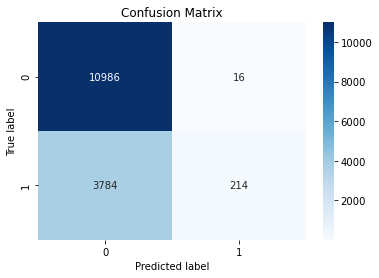

In [30]:
mlp_pipeline(clf1)

In [34]:
losses = [0.49186077,0.33885007,0.28019483,0.25849795,0.26839807,0.27504068,0.30506439,0.30173568,0.31940272,0.31854720,0.38491808,0.33769531,0.33362320,0.31822858,0.51952984]

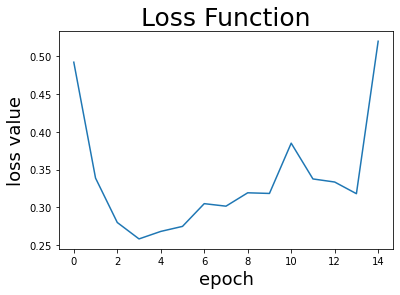

In [36]:
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.plot(losses)

In [26]:
clf4 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(500,100),solver='adam',max_iter=100,verbose=True,learning_rate="adaptive")

Iteration 1, loss = 0.45095640
Iteration 2, loss = 0.32264742
Iteration 3, loss = 0.28246963
Iteration 4, loss = 0.25420961
Iteration 5, loss = 0.22714410
Iteration 6, loss = 0.21668556
Iteration 7, loss = 0.20236626
Iteration 8, loss = 0.19336735
Iteration 9, loss = 0.25130103
Iteration 10, loss = 0.26460682
Iteration 11, loss = 0.24749870
Iteration 12, loss = 0.21447996
Iteration 13, loss = 0.18785226
Iteration 14, loss = 0.17101251
Iteration 15, loss = 0.16755544
Iteration 16, loss = 0.16009359
Iteration 17, loss = 0.15640802
Iteration 18, loss = 0.15560491
Iteration 19, loss = 0.19960598
Iteration 20, loss = 0.21710439
Iteration 21, loss = 0.21891133
Iteration 22, loss = 0.23245732
Iteration 23, loss = 0.22602136
Iteration 24, loss = 0.22045110
Iteration 25, loss = 0.21191584
Iteration 26, loss = 0.21565911
Iteration 27, loss = 0.20165730
Iteration 28, loss = 0.19929792
Iteration 29, loss = 0.20204708
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

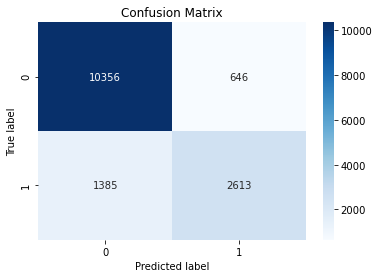

In [27]:
mlp_pipeline(clf4)

In [29]:
# oversample implementation
from imblearn.over_sampling import SMOTE

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler(random_state=42,sampling_strategy=0.9)
x_train, y_train = oversample.fit_resample(x_train, y_train)

Iteration 1, loss = 0.45326188
Iteration 2, loss = 0.31300272
Iteration 3, loss = 0.25596418
Iteration 4, loss = 0.23238772
Iteration 5, loss = 0.21124959
Iteration 6, loss = 0.20251263
Iteration 7, loss = 0.20501424
Iteration 8, loss = 0.18075419
Iteration 9, loss = 0.17299856
Iteration 10, loss = 0.19146705
Iteration 11, loss = 0.26030485
Iteration 12, loss = 0.20467961
Iteration 13, loss = 0.18405184
Iteration 14, loss = 0.16926886
Iteration 15, loss = 0.16930555
Iteration 16, loss = 0.16689334
Iteration 17, loss = 0.16862678
Iteration 18, loss = 0.16211799
Iteration 19, loss = 0.21781083
Iteration 20, loss = 0.15842945
Iteration 21, loss = 0.14819519
Iteration 22, loss = 0.14282927
Iteration 23, loss = 0.13915942
Iteration 24, loss = 0.14382271
Iteration 25, loss = 0.13579911
Iteration 26, loss = 0.13237113
Iteration 27, loss = 0.17389022
Iteration 28, loss = 0.22270478
Iteration 29, loss = 0.24749279
Iteration 30, loss = 0.22262463
Iteration 31, loss = 0.18442084
Iteration 32, los

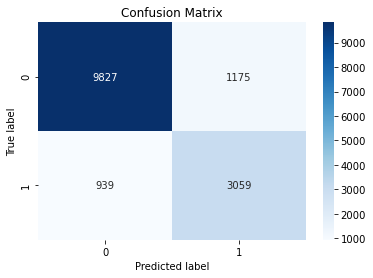

In [31]:
mlp_pipeline(clf4)

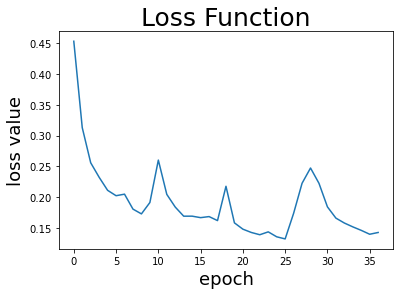

In [35]:
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.plot(clf4.loss_curve_)

In [37]:
clf2 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(1000,500,100,50),solver='adam',max_iter=10000,verbose=True)

Iteration 1, loss = 0.48971795
Iteration 2, loss = 0.30826715
Iteration 3, loss = 0.24823736
Iteration 4, loss = 0.20594403
Iteration 5, loss = 0.19883064
Iteration 6, loss = 0.18704543
Iteration 7, loss = 0.19016211
Iteration 8, loss = 0.17450848
Iteration 9, loss = 0.16860291
Iteration 10, loss = 0.18233587
Iteration 11, loss = 0.19114677
Iteration 12, loss = 0.17953748
Iteration 13, loss = 0.17655120
Iteration 14, loss = 0.19815418
Iteration 15, loss = 0.22945104
Iteration 16, loss = 0.26846874
Iteration 17, loss = 0.29312804
Iteration 18, loss = 0.22359564
Iteration 19, loss = 0.19047879
Iteration 20, loss = 0.18133550
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     11002
         1.0       0.75      0.76      0.76      3998

    accuracy                           0.87     15000
   macro avg       0.83      0.83      0.83     15000
weighte

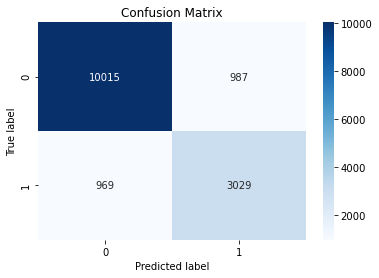

In [38]:
mlp_pipeline(clf2)

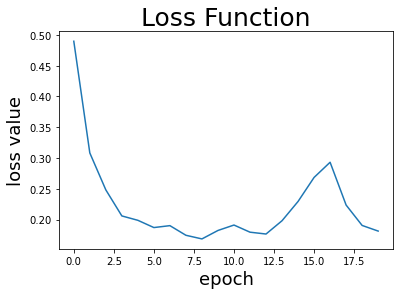

In [39]:
plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss value",fontsize=18)
plt.title("Loss Function", fontsize = 25)
plt.plot(clf2.loss_curve_)

In [ ]:
clf3 = MLPClassifier(random_state=1,learning_rate_init=0.01,batch_size=200,activation="relu",
                    hidden_layer_sizes=(1000,500,100),solver='sgd',max_iter=10000,verbose=True)